<a href="https://colab.research.google.com/github/SergChupin/NLP/blob/lesson_06/nlp_hw_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!wget -O imdb.zip -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vrQ5czMHoO3pEnmofFskymXMkq_u1dPc"
!unzip imdb.zip
!pip -q install eli5
!pip -q install spacy
!python -m spacy download en

Archive:  imdb.zip
replace test.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.tsv                
  inflating: train.tsv               
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 5.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Классификация текстов

Начнём с самого простого - анализа тональности текста.

Будем классифицировать отзывы с IMDB на положительные/отрицательные.

Датасет взят с http://ai.stanford.edu/~amaas/data/sentiment/

In [49]:
!head train.tsv

is_positive	review
0	"Dreamgirls, despite its fistful of Tony wins in an incredibly weak year on Broadway, has never been what one would call a jewel in the crown of stage musicals. However, that is not to say that in the right cinematic hands it could not be fleshed out and polished into something worthwhile on-screen. Unfortunately, what transfers to the screen is basically a slavishly faithful version of the stage hit with all of its inherent weaknesses intact. First, the score has never been one of the strong points of this production and the film does not change that factor. There are lots of songs (perhaps too many?), but few of them are especially memorable. The closest any come to catchy tunes are the title song and One Night Only - the much acclaimed And I Am Telling You That I Am Not Going is less a great song than it is a dramatic set piece for the character of Effie (Jennifer Hudson). The film is slick and technically well-produced, but the story and characters are surprisi

In [50]:
import pandas as pd

train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print('Train size = {}'.format(len(train_df)))
print('Test size = {}'.format(len(test_df)))

Train size = 25000
Test size = 25000


Посмотрите глазами на тексты? Какие есть зацепки, как определить, что это за сентимент?

Самое простое, как всегда - найти ключевые слова.

In [51]:
#@title Начинаем классифицировать! { vertical-output: true, display-mode: "form" }
positive_words = 'love', 'great', 'best', 'wonderful' #@param {type:"raw"}
negative_words = 'worst', 'awful', '1/10', 'crap' #@param {type:"raw"}

positives_count = test_df.review.apply(lambda text: sum(word in text for word in positive_words))
negatives_count = test_df.review.apply(lambda text: sum(word in text for word in negative_words))
is_positive = positives_count > negatives_count
correct_count = (is_positive == test_df.is_positive).values.sum()

accuracy = correct_count / len(test_df)

print('Test accuracy = {:.2%}'.format(accuracy))
if accuracy > 0.71:
    from IPython.display import Image, display
    display(Image('https://s3.amazonaws.com/achgen360/t/rmmoZsub.png', width=500))

Test accuracy = 66.73%


**Задание** Придумайте хорошие ключевые слова или фразы и наберите хотя бы 71% точности на тесте (и не забудьте посмотреть на код классификации!)

**Задание** Кому-нибудь нравятся эти `<br /><br />`? Лично мне - нет. Напишите регулярку, которая будет их удалять

In [52]:
import re

pattern = re.compile('<br />')

print(train_df['review'].iloc[3])
print(pattern.subn(' ', train_df['review'].iloc[3])[0])

Spoilers ahead if you want to call them that...<br /><br />I would almost recommend this film just so people can truly see a 1/10. Where to begin, we'll start from the top...<br /><br />THE STORY: Don't believe the premise - the movie has nothing to do with abandoned cars, and people finially understanding what the mysterious happenings are. It's a draub, basic, go to cabin movie with no intensity or "effort".<br /><br />THE SCREENPLAY: I usually give credit to indie screenwriters, it's hard work when you are starting out...but this is crap. The story is flat - it leaves you emotionless the entire movie. The dialogue is extremely weak and predictable boasting lines of "Woah, you totally freaked me out" and "I was wondering if you'd uh...if you'd like to..uh, would you come to the cabin with me?". It makes me want to rip out all my hair, one strand at a time and feed it to myself.<br /><br />THE CHARACTERS: HOLY CRAP!!!! Some have described the characters as flat, I want to take it one 

In [53]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.stem.wordnet import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [54]:
def removeApostropheFixed(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def removeSpecialPatterns(phrase):
    pattern = re.compile('<br />')
    return pattern.subn(' ', phrase)[0]

def removeSpecialChars(phrase):
     return re.sub('[^a-zA-Z]', ' ', phrase)

def doCleaningFixed(phrase):
    phrase = removeSpecialPatterns(phrase)
    phrase = removeApostropheFixed(phrase)
    phrase = removeSpecialChars(phrase) 
    phrase = phrase.lower()  
   
    return phrase

Применим ее:

In [55]:
train_df['review'] = train_df['review'].apply(doCleaningFixed)
test_df['review'] = test_df['review'].apply(doCleaningFixed)

train_df['review'][24999]

'this was a disappointment   none of the nuance of the original  the brits just seem to be able to make a truly unsettling film with none of the over the top histrionics of the american version  the original series combined both creepy stories and subtlety of performance with great attention to lighting and settings  i have watched the series many times and am still enthralled   just another poor adaptation along the lines of the dreadful adaptation of  cracker   get hooked up with bbc america or bbc canada and watch for such delights as waking the dead  spooks  silent witness  and judge john deed  watch the original touching evil  then look for  wire in the blood  for more of the truly understated  elegant performance of robson green  hollywood needs to have a look at this actor '

In [56]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['The movie was excellent',
              'the movie was awful']

dummy_matrix = vectorizer.fit_transform(dummy_data)

print(dummy_matrix.toarray())
print(vectorizer.get_feature_names())

[[0 1 1 1 1]
 [1 0 1 1 1]]
['awful', 'excellent', 'movie', 'the', 'was']


*Как именно vectorizer определяет границы слов? Обратите внимание на параметр `token_pattern=r'(?u)\b\w\w+\b'` - как он будет работать?*

Запустим его на реальных данных:

In [57]:
vectorizer = CountVectorizer()
vectorizer.fit(train_df['review'].values)

CountVectorizer()

Посмотрим на слова, попавшие в словарь:

In [58]:
# vectorizer.get_feature_names()

Попробуем кого-нибудь таки сконвертировать

In [59]:
vectorizer.transform([train_df['review'].iloc[3]])

<1x73817 sparse matrix of type '<class 'numpy.int64'>'
	with 205 stored elements in Compressed Sparse Row format>

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

dummy_data = ['The movie was excellent',
              'the movie was awful']
dummy_labels = [1, 0]

vectorizer = CountVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)

print(vectorizer.get_feature_names())
print(classifier.coef_)

['awful', 'excellent', 'movie', 'the', 'was']
[[-0.40104279  0.40104279  0.          0.          0.        ]]


Получилось что надо.

Запустим теперь её на реальных данных.

In [61]:
model.fit(train_df['review'], train_df['is_positive'])

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', LogisticRegression())])

In [62]:
from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test_df['is_positive'], preds)))
    
eval_model(model, test_df)

Test accuracy = 86.14%


Прогресс!

Хочется как-то посмотреть, что заинтересовало классификатор. К счастью, сделать это совсем просто:

In [63]:
import eli5
eli5.show_weights(classifier, vec=vectorizer, top=40)

Weight?,Feature
+1.971,refreshing
+1.964,wonderfully
+1.913,funniest
+1.905,surprisingly
+1.874,rare
+1.756,superb
+1.551,incredible
+1.521,perfect
+1.490,delightful
+1.466,subtle


Посмотрим на конкретные примеры его работы:

In [64]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [65]:
print('Positive' if test_df['is_positive'].iloc[6] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[6], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


Посмотрим на примеры неправильной классификации, наконец:

In [66]:
import numpy as np

preds = model.predict(test_df['review'])
incorrect_pred_index = np.random.choice(np.where(preds != test_df['is_positive'])[0])

eli5.show_prediction(classifier, test_df['review'].iloc[incorrect_pred_index],
                     vec=vectorizer, targets=['positive'], target_names=['negative', 'positive'])

## Придумываем новые признаки

### Tf-idf

Сейчас мы на все слова смотрим с одинаковым весом - хотя какие-то из них более редкие, какие-то более частые, и эта частотность - полезная, вообще говоря, информация.

Самый простой способ добавить статистическую информацию о частотностях - сделать *tf-idf* взвешивание:

$$\text{tf-idf}(t, d) = \text{tf}(t, d) \times \text{idf}(t)$$

*tf* - term-frequency - частотность слова `t` в конкретном документе `d` (рецензии в нашем случае). Это ровно то, что мы уже считали.

*idf* - inverse document-frequency - коэффициент, который тем больше, чем в меньшем числе документов встречалось данное слово. Считается как-нибудь так:
$$\text{idf}(t) = \text{log}\frac{1 + n_d}{1 + n_{d(t)}} + 1$$
где $n_d$ - число всех документов, а $n_{d(t)}$ - число документов со словом `t`.

Использовать его просто - нужно заменить `CountVectorizer` на `TfidfVectorizer`.

**Задание** Попробуйте запустить `TfidfVectorizer`. Посмотрите на ошибки, которые он научился исправлять, и на ошибки, которые он начал делать - по сравнению с `CountVectorizer`.

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.38%


### N-граммы слов

До сих пор мы смотрели на тексты как на мешок слов - но очевидно, что есть разница между `good movie` и `not good movie`.

Добавим информацию (хоть какую-то) о последовательностях слов - будем извлекать еще и биграммы слов.

В Vectorizer'ах для этого есть параметр `ngram_range=(n_1, n_2)` - он говорит, что нужны n_1-...n_2-граммы.

**Задание** Попробуйте увеличенный range и поинтерпретируйте полученный результат.

In [68]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.82%


### N-граммы символов

Символьные n-граммы дают простой способ выучить полезные корни и суффиксы, не связываясь с этой вашей лингвистикой - только статистика, только хардкор.

Например, слово `badass` мы можем представить в виде такой последовательности триграмм:

`##b #ba bad ada das ass ss# s##`

So interpretable, неправда ли?

Реализовать это дело всё так же просто - нужно поставить `analyzer='char'` в вашем любимом Vectorizer'е и выбрать размер `ngram_range`.

**Задание** Запилите классификатор на n-граммах символов и визуализируйте его.

In [69]:
vectorizer = TfidfVectorizer(ngram_range=(2, 6), max_features=20000, analyzer='char')
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 87.66%


In [70]:
print('Positive' if test_df['is_positive'].iloc[1] else 'Negative')
eli5.show_prediction(classifier, test_df['review'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


## Подключаем лингвистику

### Лемматизация и стемминг

Если присмотреться, можно найти формы одного слова с разной семантической окраской по мнению классификатора. Или нет?

**Задание** Найти формы слова с разной семантической окраской.

Поверя, что они есть, попробуем что-нибудь с этим сделать.

Например, лемматизируем - сведем к начальной форме все слова. Поможет в этом библиотека spacy.

In [71]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm', disable=['parser'])

docs = [doc for doc in nlp.pipe(train_df.review.values[:50])]

In [72]:
for token in docs[0]:
    print(token.text, token.lemma_, token.ent_iob_, token.ent_type_)

dreamgirls dreamgirl O 
    O 
despite despite O 
its its O 
fistful fistful O 
of of O 
tony tony O 
wins win O 
in in O 
an an B DATE
incredibly incredibly I DATE
weak weak I DATE
year year I DATE
on on O 
broadway broadway O 
    O 
has have O 
never never O 
been be O 
what what O 
one one O 
would would O 
call call O 
a a O 
jewel jewel O 
in in O 
the the O 
crown crown O 
of of O 
stage stage O 
musicals musical O 
    O 
however however O 
    O 
that that O 
is be O 
not not O 
to to O 
say say O 
that that O 
in in O 
the the O 
right right O 
cinematic cinematic O 
hands hand O 
it it O 
could could O 
not not O 
be be O 
fleshed flesh O 
out out O 
and and O 
polished polish O 
into into O 
something something O 
worthwhile worthwhile O 
on on O 
screen screen O 
    O 
unfortunately unfortunately O 
    O 
what what O 
transfers transfer O 
to to O 
the the O 
screen screen O 
is be O 
basically basically O 
a a O 
slavishly slavishly O 
faithful faithful O 
version versi

**Задание** Сделайте классификатор на лемматизированных текстах.

Более простой способ нормализации слов - использовать стемминг. Он немного тупой, не учитывает контекст, но иногда оказывается даже эффективнее лемматизации - а, главное, быстрее.

По сути это просто набор правил, как обрезать слово, чтобы получить основу (stem):

In [73]:
from nltk import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    text = text.split()
    review = [stemmer.stem(token) for token in text]
    text = " ".join(text)    
    return text

train_df['review'] = train_df['review'].apply(stem_text)
test_df['review'] = test_df['review'].apply(stem_text)

In [74]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.82%


**Задание** Попробуйте вместо лемм классифицировать основы.

### NER

В текстах рецензий очень много именованных сущностей. Вот, например:

In [75]:
displacy.render(docs[0], style='ent', jupyter=True)

Вообще говоря, почему вдруг какой-нибудь Депп должен нести семантическую окраску? Однако оказывается, что классификатор выучивает, что какие-то имена чаще в положительных рецензиях - или наоборот. Это похоже на переобучение - почему бы не попробовать вырезать сущности?

**Задание** Удалите из текстов какие-то из сущностей, пользуясь координатами из запикленных файлов. Описание сущностей можно посмотреть [здесь](https://spacy.io/api/annotation#named-entities). Запустите классификатор.

In [76]:
def del_entity(text, entity, parser):
    token_list = []
    doc = parser(text)
    for token in doc:
        if (token.ent_iob_ == 'B') and (token.ent_type_ == entity):
            token_list.append(entity)
        elif (token.ent_iob_ == 'I') and (token.ent_type_ == entity):
            continue
        else:
            token_list.append(token.text)
    return token_list

In [77]:
train_df['review_without_org'] = train_df['review'].apply(lambda x: del_entity(x, 'ORG', nlp))
train_df['review_without_org_text'] = train_df['review_without_org'].apply(lambda x: ' '.join(x))

train_df.head()

,is_positive,review,review_without_org,review_without_org_text
0,0,dreamgirls despite its fistful of tony wins in...,"[ORG, despite, its, fistful, of, tony, wins, i...",ORG despite its fistful of tony wins in an inc...
1,0,this show comes up with interesting locations ...,"[this, show, comes, up, with, interesting, loc...",this show comes up with interesting locations ...
2,1,i simply love this movie i also love the ramon...,"[i, simply, love, this, movie, i, also, love, ...",i simply love this movie i also love the ramon...
3,0,spoilers ahead if you want to call them that i...,"[spoilers, ahead, if, you, want, to, call, the...",spoilers ahead if you want to call them that i...
4,1,my all time favorite movie i have seen many mo...,"[my, all, time, favorite, movie, i, have, seen...",my all time favorite movie i have seen many mo...


In [78]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(train_df['review_without_org_text'], train_df['is_positive'])

eval_model(model, test_df)

Test accuracy = 88.82%


## Включаем дип лёрнинг

Мы тут пришли deep learning'ом заниматься, а делаем почему-то модель на логистической регрессии. Как так?

Попробуем запустить относительно стандартную модель для классификации текстов - сверточная сеть поверх словных эмбеддингов.

Разбираться, что это за зверь, будем на следующих занятиях, а пока будем просто им пользоваться :)

Каждое предложение нужно представлять набором слов - и сразу же начинаются проблемы. Во-первых, как ограничить длину предложения?

Прикинем по гистограмме, какая длина нам подходит:

In [79]:
train_df['review']

0        dreamgirls despite its fistful of tony wins in...
1        this show comes up with interesting locations ...
2        i simply love this movie i also love the ramon...
3        spoilers ahead if you want to call them that i...
4        my all time favorite movie i have seen many mo...
                               ...                        
24995    i am a big fan of the movie but not for the us...
24996    i am not going to bother with a plot synopsis ...
24997    this movie i do not know why they would take s...
24998    saw this film on dvd yesterday and was gob sma...
24999    this was a disappointment none of the nuance o...
Name: review, Length: 25000, dtype: object

<a list of 230 Patch objects>

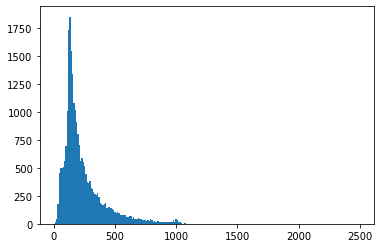

In [80]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(train_df.review.apply(lambda text: len(text.split())), bins='auto')
hist

Кроме этого, нужно перенумеровать как-то слова.

In [81]:
from collections import Counter

words_counter = Counter((word for text in train_df.review for word in text.lower().split()))

word2idx = {
    '': 0,
    '<unk>': 1
}
for word, count in words_counter.most_common():
    if count < 10:
        break
        
    word2idx[word] = len(word2idx)
    
print('Words count', len(word2idx))

Words count 19876


**Задание** Сконвертируйте данные

In [82]:
def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)
    
    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)
    return data

X_train = convert(train_df.review, word2idx, 1000)
X_test = convert(test_df.review, word2idx, 1000)

Поставим учиться модельку на keras.

*Напоминание*: на keras, чтобы обучить модель, нужно
1. Определить модель, например:
```python 
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=NUM_WORDS))
```
2. Задать функцию потерь и оптимизатор:
```python
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
```

3. Запустить обучение:
```python
model.fit(X_train, y_train, 
          batch_size=32,
          epochs=3,
          validation_data=(X_test, y_test))
```

В NLP чаще всего ставятся задачи классификации, поэтому нужно запомнить такие функции потерь:

*   **categorical_crossentropy** - для многоклассовой классификации, в качестве меток должны передаваться one-hot-encoding вектора
*   **sparse_categorical_crossentropy** - аналогично предыдущему, но в качестве меток нужно передавать просто индексы соответствующих классов
*   **binary_crossentropy** - для бинарной классификации


В качестве оптимизатора обычно используют `sgd` или `adam`.


In [83]:
import tensorflow as tf
tf.__version__

'2.8.2'

In [84]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalMaxPooling1D, Dropout

In [85]:
model = Sequential([
    Embedding(input_dim=len(word2idx), output_dim=64, input_shape=(X_train.shape[1],)),
    GlobalMaxPooling1D(),
    Dense(units=10, activation='relu'),
    Dense(units=10, activation='relu'),

    Dense(units=1, activation='sigmoid')
])

model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 64)          1272064   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,272,835
Trainable params: 1,272,835
Non-trainable params: 0
____________________________________________

In [86]:
model.fit(X_train, train_df.is_positive, batch_size=128, epochs=10, 
          validation_data=(X_test, test_df.is_positive))

Epoch 1/10
196/196 [==============================] - 3s 12ms/step - loss: 0.6034 - accuracy: 0.6900 - val_loss: 0.4196 - val_accuracy: 0.8475
Epoch 2/10
196/196 [==============================] - 2s 10ms/step - loss: 0.2989 - accuracy: 0.8865 - val_loss: 0.3012 - val_accuracy: 0.8728
Epoch 3/10
196/196 [==============================] - 2s 9ms/step - loss: 0.1895 - accuracy: 0.9305 - val_loss: 0.3026 - val_accuracy: 0.8744
Epoch 4/10
196/196 [==============================] - 2s 10ms/step - loss: 0.1168 - accuracy: 0.9631 - val_loss: 0.3255 - val_accuracy: 0.8700
Epoch 5/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0655 - accuracy: 0.9828 - val_loss: 0.3649 - val_accuracy: 0.8659
Epoch 6/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0315 - accuracy: 0.9946 - val_loss: 0.4081 - val_accuracy: 0.8614
Epoch 7/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0140 - accuracy: 0.9984 - val_loss: 0.4535 - val_accuracy: 0.8602


**Задание** Подсчитайте качество модели на тесте